# <u><b>Objective: Predict when a particular cycle station will run out of bikes using time series analysis and machine learning</b></u>

## <u>Introduction:-</u>




## <u>Objective:-</u>
This study was undertaken by me on behalf of the bike sharing company. The objective,is to build a model which is able to predict if a particular station will run out of bikes within two hours. If the model is able to predict this with reasonalble accuracy, it is possible for the bike sharing company to replinish the station with more bikes.

If a station requires bikes, an alert message can be sent to a central command center which can then dispatch a truck/vehicle carrying more bikes to replenish the station which sent the alert.

Since there are a number of stations, the model has been built on the station with the highest traffic. It can then be applied to all the other stations as required. 

## <u>Data Set Information:-</u>

The data set includes the following files.

> Station.csv : Contains station information like name, location and number of docks available (70 rows)

> Status.csv: This is sensor data for every minute for each station. It shows the number of bikes available at the station at that minute (72 M records)

     > station_id
     > Bikes_available
     > Docks_available
     > Time
    
> trip.csv: Contains trip related information for each station (670K Rows)

     > ID
     > duration
     > start_date
     > end_date
     > start_station_id
     > end_station_id
     > bike_id
    
> weather.csv: Contains weather related data for each day for each zip code (3665 rows)
    
 The data set is quiet large (approximately 660MB), which is why its a good data set to experiment with pyspark. Because I have worked on a single machine instead of a cluster, I have used basic pyspark here to read and extract the data.
 
 <u><b>Remark on Data Quality:-</b></u>
 The data quality was generally good. However, the time stamps were inconsistent in a few places. The weather data also had some incorrect values in columns which were handled. 
 
 
 ## <u>Methodology</u>

### Objective and Approach

### Data Import and Cleaning

### Exploratory Data Analysis using Data Vizualizations

### Models 

#### *Logistic Regression*
   
   #### *K-Nearest Neighbours*
   
   #### *Decision Tree Classification*
   
   #### *Random Forest*
   
   
### Model Evaluation

Model evaluation is done based on the following parameters:-

 - Accuracy
 - ROC curve
 - Precision
 - Recall
 
 
 ### Assumptions and Limitations

#### Assumptions

#### Limitations

## <u>Conclusion and Client Recommendation</u>

## <u>Future Research</u>

#### Deeper Exploratory Analysis

#### Application layer

#### Applications in other similar industries




In [1]:
#For timeseries analysis and dataframes
import pandas as pd
import datetime
#For Plots
import matplotlib.pyplot as plt
#Create Spark context
from pyspark.sql import SparkSession
#Importing Spark datatypes and SQL functions in order to create schema for tables
from pyspark.sql.types import *
from pyspark.sql.functions import *
import geopy.distance

spark = SparkSession.builder.appName('SFBikeShareProd').getOrCreate()

In [2]:
#Supervised learning models
from sklearn.model_selection import train_test_split
#from sklearn import cross_validation
#Logistic Regression
from sklearn.linear_model import LogisticRegression
#kNN
from sklearn.neighbors import KNeighborsClassifier
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier


#Model performance
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

#Hyper Parameter tuning
from sklearn.model_selection import GridSearchCV

#Math functions used for feature engineering
from math import log

#numpy
import numpy as np

### Importing data by specifying a schema and Cleaning Data
Below, we are importing the different tables along with their schemas. 
The tables imported for our initial analysis are"-

1. trip : contains trip details
2. station: station identification and location details
3. status: dock status at each station

When I imported the schema by specifying the timestamp fields in the initial load itself, I realised that the date fields were differently formatted for different time periods. The actual data begins from 2013-8-29 but when I imported the incorrect data, I get the following. The dataframe saves the dates starting from 2013-01-29. Also, it doesnt read the different date format which is why I thought that the dataset includes only one month data set from each year. 

In [3]:
##Importing dataset without fixing the date fields
##Importing CSV file directly using pyspark by specifying schema
trip_schema_corrected = StructType ([StructField ("id" , IntegerType(), True), StructField("duration", FloatType(), True),StructField("start_date", TimestampType(),True), StructField("start_station_name", StringType(), True), StructField("start_station_id", IntegerType(), True), StructField("end_date", TimestampType(),True), StructField("end_station_name", StringType(), True)\
									   , StructField("end_station_id", IntegerType(), True), StructField("bike_id", IntegerType(), True), StructField("subscription_type", StringType(), True), StructField("zip_code", StringType(), True)])
df_trip_2 = spark.read.load('D:/Data Sets/SF Bike Sharing Data/sf-bay-area-bike-share/trip.csv', format='csv', header='true',timestampFormat='mm/dd/yyyy hh:mm', schema=trip_schema_corrected)
df_trip_2.createOrReplaceTempView('trip_2')
df_trip_2.dtypes
df_trip_2.head(5)

[Row(id=4576, duration=63.0, start_date=datetime.datetime(2013, 1, 29, 14, 13), start_station_name='South Van Ness at Market', start_station_id=66, end_date=datetime.datetime(2013, 1, 29, 14, 14), end_station_name='South Van Ness at Market', end_station_id=66, bike_id=520, subscription_type='Subscriber', zip_code='94127'),
 Row(id=4607, duration=70.0, start_date=datetime.datetime(2013, 1, 29, 14, 42), start_station_name='San Jose City Hall', start_station_id=10, end_date=datetime.datetime(2013, 1, 29, 14, 43), end_station_name='San Jose City Hall', end_station_id=10, bike_id=661, subscription_type='Subscriber', zip_code='95138'),
 Row(id=4130, duration=71.0, start_date=datetime.datetime(2013, 1, 29, 10, 16), start_station_name='Mountain View City Hall', start_station_id=27, end_date=datetime.datetime(2013, 1, 29, 10, 17), end_station_name='Mountain View City Hall', end_station_id=27, bike_id=48, subscription_type='Subscriber', zip_code='97214'),
 Row(id=4251, duration=77.0, start_date=

The issue with the trip data set is that some of the dates are in the format '28-8-2013' whereas some other dates are in the format '23/8/2013'. In order to obtain correct dates, all '-' are replaced with '/'. 

In [4]:
##Importing dataset with the corrected date fields
trip_schema_2 = StructType ([StructField ("id" , IntegerType(), True), StructField("duration", FloatType(), True),StructField("start_date", StringType(),True), StructField("start_station_name", StringType(), True), StructField("start_station_id", IntegerType(), True), StructField("end_date", StringType(),True), StructField("end_station_name", StringType(), True)\
									   , StructField("end_station_id", IntegerType(), True), StructField("bike_id", IntegerType(), True), StructField("subscription_type", StringType(), True), StructField("zip_code", StringType(), True)])
df_trip_3 = spark.read.load('D:/Data Sets/SF Bike Sharing Data/sf-bay-area-bike-share/trip.csv', format='csv', header='true', schema=trip_schema_2)
df_trip_3.createOrReplaceTempView('trip_3')
##Correcting the date fields - replacing the '-' with '/' for consistency across all date fields
df_trip_3.withColumn('start_date', regexp_replace('start_date','-','/') )
df_trip_3.withColumn('end_date', regexp_replace('end_date','-','/') )
#Converting the start_date and end_date to timestamp. This SQL function doesnt work as seen below in the datatypes
df_trip_3.withColumn('start_date', to_timestamp('start_date', 'mm/dd/yyyy hh:mm'))
df_trip_3.withColumn('end_date', to_timestamp('end_date', 'mm/dd/yyyy hh:mm'))
df_trip_3.dtypes

[('id', 'int'),
 ('duration', 'float'),
 ('start_date', 'string'),
 ('start_station_name', 'string'),
 ('start_station_id', 'int'),
 ('end_date', 'string'),
 ('end_station_name', 'string'),
 ('end_station_id', 'int'),
 ('bike_id', 'int'),
 ('subscription_type', 'string'),
 ('zip_code', 'string')]

In [5]:
##Importing station data
#reading station data
station_schema =StructType([StructField("id", IntegerType(), True), StructField("name", StringType(), True), StructField("lat", FloatType(),True), StructField("long", FloatType(), True), StructField("dock_count", IntegerType(),True),  StructField("city",StringType(), True), StructField("installation_date",DateType(), True)])
df_station = spark.read.load('D:/Data Sets/SF Bike Sharing Data/sf-bay-area-bike-share/station.csv', format='csv', header='true', schema=station_schema)
df_station.createOrReplaceTempView('station')

For initial analysis, I am considering the station data of only one station. Station with id = 70. 
This is bacuase the volume of data is large. Also, station 70 has the highest volume of trips when compared to all other stations which makes it a good case for analyzing the data. 

Since the objective of my analysis is limited to individual stations, I am considering one station at a time. Any exploratory analysis done here, can also be applied to all the other stations. 

In [6]:
#Combining trip and station data. We are getting the number of cycles available for the station and latitude and longitude information of destination stations
station_70_detailed = spark.sql('select a.id, (a.duration/60) as trip_duration, a.start_station_name, a.start_date, a.start_station_id, b.lat, b.long, a.end_date, a.end_station_id, a.bike_id, a.subscription_type, a.zip_code, b.city, b.dock_count from trip_3 a LEFT OUTER JOIN station b ON a.start_station_id = b.id WHERE a.start_station_id = 70')
station_70_detailed.collect()
station_70_detailed.createOrReplaceTempView('iter_1')
#Joining the data together
station_70_detailed_2 = spark.sql('select a.id, a.trip_duration,a.start_station_name, a.start_date, a.start_station_id, a.lat, a.long, a.end_date, a.end_station_id, b.lat as lat_end, b.long as long_end,  a.bike_id, a.subscription_type, a.zip_code, a.city, a.dock_count from iter_1 a LEFT OUTER JOIN station b ON a.end_station_id = b.id')
station_70_detailed_2.show(5)

+----+------------------+--------------------+---------------+----------------+---------+----------+---------------+--------------+---------+----------+-------+-----------------+--------+-------------+----------+
|  id|     trip_duration|  start_station_name|     start_date|start_station_id|      lat|      long|       end_date|end_station_id|  lat_end|  long_end|bike_id|subscription_type|zip_code|         city|dock_count|
+----+------------------+--------------------+---------------+----------------+---------+----------+---------------+--------------+---------+----------+-------+-----------------+--------+-------------+----------+
|4673|3.9833333333333334|San Francisco Cal...|8/29/2013 15:48|              70|37.776615|-122.39526|8/29/2013 15:52|            65|37.771057|-122.40272|    568|       Subscriber|   94110|San Francisco|        19|
|4177| 4.633333333333334|San Francisco Cal...|8/29/2013 11:03|              70|37.776615|-122.39526|8/29/2013 11:08|            64| 37.78226|-122.39

### Helper Methods

#### Calculating the distance between two points given latitude and longitude.

In [7]:
#Calculates distance between two points given coordinates
def calcDistance(x):
    coords_1 = (x[0], x[1])
    coords_2 = (x[2], x[3])
    return geopy.distance.vincenty(coords_1, coords_2).km

In [8]:
# Functions to Calculating the outgoing and incoming bikes
def outgoing(row, station_id):
    if row['start_station_id'] == station_id:
        return 1
    if row['end_station_id'] == station_id:
        return 0

def incoming(row, station_id):
     if row['start_station_id'] == station_id:
        return 0
     if row['end_station_id'] == station_id:
        return 1    

In [9]:
#Threshold function: this 
def threshold(row):
    if row['bikes_available'] < 4:
        return 1
    if row['bikes_available'] >=0:
        return 0

### Initial Exploratory Analysis of the data

1. Trips from each station
2. subscriber makeup

Pending
1. Average trip duration from each station (or top 10)
2. Average trip length from each station (or top 10)
3. Yearly/Monthly/Weekly averages of trip duration and lengths
4. Mileage per bike - useful in identifying possible repairs/replacements

<function matplotlib.pyplot.show(*args, **kw)>

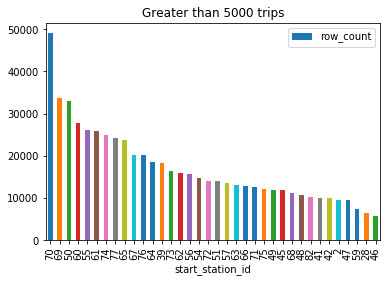

<Figure size 2520x2520 with 0 Axes>

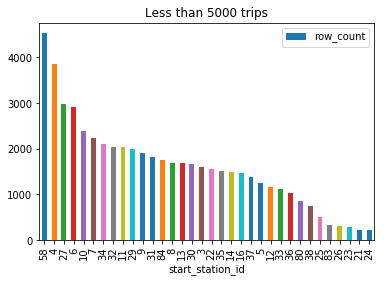

<Figure size 2520x2520 with 0 Axes>

In [10]:
#Number of trips from each station
trip_count=spark.sql('select start_station_id,count(*) as row_count from trip_3 group by start_station_id order by count(*) desc')
pd_trip_count = trip_count.toPandas()

#getting trip counts by station
pd_trip_count.count()
pd_trip_count_max = pd_trip_count.loc[pd_trip_count['row_count']>5000]
pd_trip_count_min = pd_trip_count.loc[pd_trip_count['row_count']<5000]

#Number of trips from the top stations
pd_trip_count_max.plot.bar(grid=False, x='start_station_id', y='row_count', title='Greater than 5000 trips')
plt.figure(figsize=(35,35))

#Number of trips from the bottom stations
pd_trip_count_min.plot.bar(grid=False, x='start_station_id', y='row_count', title='Less than 5000 trips')
plt.figure(figsize=(35,35))

plt.show

In [11]:
#Customer makeup - Subscriber vs One-time customer
subscriber_type_trips=spark.sql('select subscription_type,count(*) as trip_count from trip_3 group by subscription_type order by count(*) desc')
pd_subscr_type_trips = subscriber_type_trips.toPandas()

                   trip_count
subscription_type            
Subscriber             566746
Customer               103213


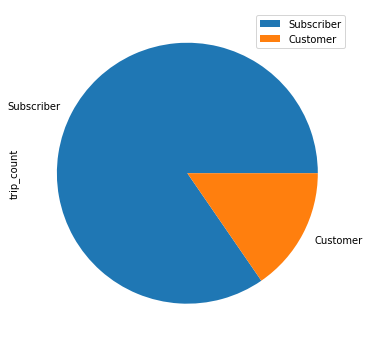

In [12]:
#Customer makeup - Subscriber vs One-time customer
pd_subscriber_type_trips = pd_subscr_type_trips.set_index(['subscription_type'])
print(pd_subscriber_type_trips)
pd_subscriber_type_trips.plot.pie(y='trip_count', figsize=(6,6))
plt.show()

### Time series exploratory analysis using pandas - Station 70

1. Trip Durations for each year
2. Trip Lengths for each year/month
3. Average trip lengths by month/week
2. Number of trips by month 

In [13]:
## Time series - analyzing data from one station
pd_station_70 = station_70_detailed_2.toPandas()
pd_station_70['start_date'] = pd.to_datetime(pd_station_70['start_date'])
pd_station_70['end_date'] = pd.to_datetime(pd_station_70['end_date'])
#Setting start_date as index
pd_station_70.set_index('start_date', inplace=True)

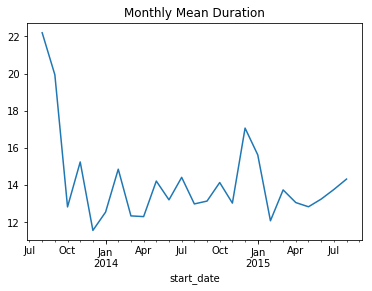

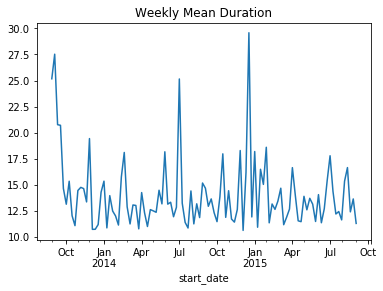

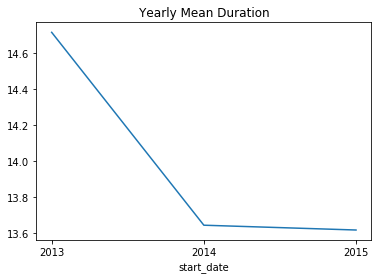

In [14]:
#Converting seconds to minutes
#pd_station_70['dur_min'] = round(pd_station_70['duration']/60,1)

#General time series on duration
#pd_station_70.trip_duration.plot(figsize=(20,20))
pd_station_70.trip_duration.resample('M').mean().plot(title = 'Monthly Mean Duration')
plt.show()

pd_station_70.trip_duration.resample('W').mean().plot(title = 'Weekly Mean Duration')
plt.show()

pd_station_70.trip_duration.resample('Y').mean().plot(title = 'Yearly Mean Duration')
plt.show()

In [15]:
#Calculating the trip lengths
pd_station_70['distance'] = pd_station_70[['lat', 'long', 'lat_end', 'long_end']].apply(calcDistance, axis=1)

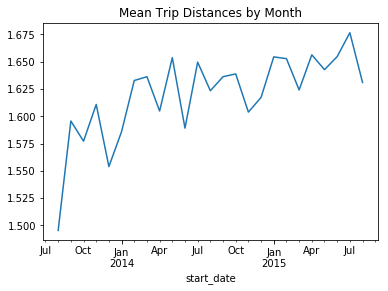

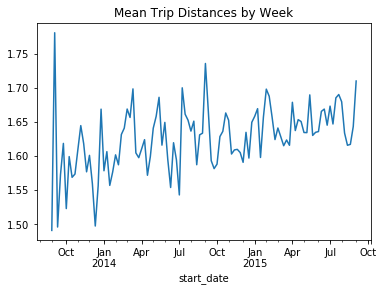

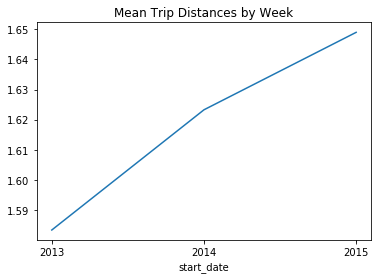

In [16]:
#Plotting mean trip distances
pd_station_70.distance.resample('M').mean().plot(title='Mean Trip Distances by Month')
plt.show()

pd_station_70.distance.resample('W').mean().plot(title='Mean Trip Distances by Week')
plt.show()

pd_station_70.distance.resample('Y').mean().plot(title='Mean Trip Distances by Week')
plt.show()

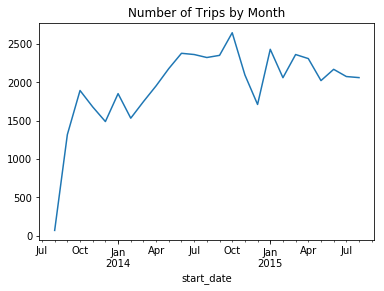

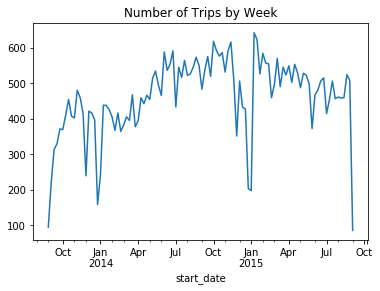

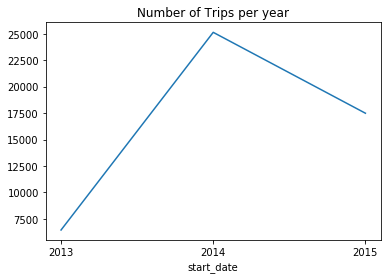

In [17]:
#Total Number of Trips per month
pd_station_70.id.resample('M').count().plot(title='Number of Trips by Month')
plt.show()
pd_station_70.id.resample('W').count().plot(title='Number of Trips by Week')
plt.show()
pd_station_70.id.resample('Y').count().plot(title='Number of Trips per year')
plt.show()

### Data Manipulation for Model Development

In [18]:
pd_station_70['trip_count'] = 1
#pd_station_70 = pd_station_70['trip_count'].resample('m').sum()

In [19]:
#Getting all trip data for station 70 
# 'All' means trips coming into station 70 and trips going out of station 70
station_70_all = spark.sql('select * from trip_3 where start_station_id = 70 OR end_station_id = 70')
station_70_all.createOrReplaceTempView('stat70_all')
station_70_all_details = spark.sql('select a.id, (a.duration/60) as trip_duration, a.start_station_name, a.start_date, a.start_station_id, b.lat, b.long, a.end_date, a.end_station_id, a.bike_id, a.subscription_type, a.zip_code, b.city, b.dock_count from stat70_all a LEFT OUTER JOIN station b ON a.start_station_id = b.id')
station_70_all_details.collect()
station_70_all_details.createOrReplaceTempView('iter_3')

station_70_all_details_final = spark.sql('select a.id, a.trip_duration,a.start_station_name, a.start_date, a.start_station_id, a.lat, a.long, a.end_date, a.end_station_id, b.lat as lat_end, b.long as long_end,  a.bike_id, a.subscription_type, a.zip_code, a.city, a.dock_count as start_stat_dock_count, b.dock_count as end_stat_dock_count from iter_3 a LEFT OUTER JOIN station b ON a.end_station_id = b.id')
station_70_all_details_final.show(5)


+----+------------------+--------------------+---------------+----------------+---------+----------+---------------+--------------+---------+----------+-------+-----------------+--------+-------------+---------------------+-------------------+
|  id|     trip_duration|  start_station_name|     start_date|start_station_id|      lat|      long|       end_date|end_station_id|  lat_end|  long_end|bike_id|subscription_type|zip_code|         city|start_stat_dock_count|end_stat_dock_count|
+----+------------------+--------------------+---------------+----------------+---------+----------+---------------+--------------+---------+----------+-------+-----------------+--------+-------------+---------------------+-------------------+
|4673|3.9833333333333334|San Francisco Cal...|8/29/2013 15:48|              70|37.776615|-122.39526|8/29/2013 15:52|            65|37.771057|-122.40272|    568|       Subscriber|   94110|San Francisco|                   19|                 15|
|5105| 4.083333333333333

In [20]:
#Converting to pandas df for easier time series analysis
pd_station_70_all = station_70_all_details_final.toPandas()

In [21]:
#Setting time stamps and index
pd_station_70_all['start_date'] = pd.to_datetime(pd_station_70_all['start_date'])
pd_station_70_all['end_date'] = pd.to_datetime(pd_station_70_all['end_date'])
#setting start time as index for new dataframe
pd_station_70_all.set_index('start_date', inplace=True)
pd_station_70_all = pd_station_70_all.sort_index()

### Feature Building

In [22]:
#Cycle availability - based on incoming and outgoing trip
cycle_count = 19
cycle_availability = []

for x in pd_station_70_all['start_station_id']:
    if x == 70:
        cycle_availability.append(cycle_count-1)
        cycle_count = cycle_count-1
    elif x!=70:
        cycle_availability.append(cycle_count+1)
        cycle_count = cycle_count + 1

pd_station_70_all['cycles_available']= cycle_availability        


In [23]:
#Adding outgoing and incoming columns to the data set
pd_station_70_all['outgoing'] = pd_station_70_all.apply(lambda row: outgoing(row, 70), axis=1)
pd_station_70_all['incoming'] = pd_station_70_all.apply(lambda row: incoming(row, 70), axis=1)

In [24]:
pd_station_70_all.head(5)

,id,trip_duration,start_station_name,start_station_id,lat,long,end_date,end_station_id,lat_end,long_end,bike_id,subscription_type,zip_code,city,start_stat_dock_count,end_stat_dock_count,cycles_available,outgoing,incoming
start_date,,,,,,,,,,,,,,,,,,,
2013-08-29 11:03:00,4177,4.633333,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:08:00,64,37.782261,-122.392738,371,Subscriber,94117,San Francisco,19,15,18,1,0
2013-08-29 11:17:00,4218,26.550000,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:43:00,66,37.774815,-122.418953,377,Subscriber,94114,San Francisco,19,19,17,1,0
2013-08-29 11:17:00,4217,25.583333,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:42:00,66,37.774815,-122.418953,370,Subscriber,94703,San Francisco,19,19,16,1,0
2013-08-29 11:18:00,4221,25.000000,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:43:00,66,37.774815,-122.418953,546,Subscriber,94123,San Francisco,19,19,15,1,0
2013-08-29 11:18:00,4219,19.166667,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:37:00,72,37.781040,-122.411751,597,Subscriber,97214,San Francisco,19,23,14,1,0


In [25]:
##resampling data hourly
#saving to two series: Outgoing cycles per hour 
outgoing_per_hour = pd_station_70_all['outgoing'].resample('30T', label='left').sum()
#Incoming Cycles per Hour
incoming_per_hour = pd_station_70_all['incoming'].resample('30T', label='left').sum()

In [26]:
#Reading the status table which contains dock availability data
dockstatus_df = spark.read.load('D:\Data Sets\SF Bike Sharing Data\sf-bay-area-bike-share/status.csv', format='csv', header='true',timestampFormat='mm/dd/yyyy hh:mm')
dockstatus_df.createOrReplaceTempView('status')
#Getting the status of just station 70
dock_status_70 = spark.sql( 'select * from status where station_id = 70')
#converting dataframe to pandas
p_df_dock_status_70 = dock_status_70.toPandas()
#Setting timestamp as index after converting datatype
p_df_dock_status_70['time'] = pd.to_datetime(p_df_dock_status_70['time'])
p_df_dock_status_70.set_index('time', inplace=True)
p_df_dock_status_70.sort_index()

,station_id,bikes_available,docks_available
time,,,
2013-08-29 12:06:01,70,0,19
2013-08-29 12:07:01,70,0,19
2013-08-29 12:08:01,70,0,19
2013-08-29 12:09:01,70,0,19
2013-08-29 12:10:01,70,0,19
2013-08-29 12:11:01,70,0,19
2013-08-29 12:12:01,70,0,19
2013-08-29 12:13:01,70,0,19
2013-08-29 12:15:01,70,0,19


In [27]:
#Resampling Dock Status for every 30 mins 
#Doing this because the status table is for every minute
p_df_new_dockStatus = p_df_dock_status_70.resample('30T', label='left').last()

In [28]:
#Joining the dock status with outgoing and incoming data calculated earlier
#This will be our main data set and we will build more features on this set
data_frames = [p_df_new_dockStatus,outgoing_per_hour, incoming_per_hour]
bike_availability_df = pd.concat(data_frames, join = 'inner', axis=1, join_axes=[p_df_new_dockStatus.index])

#### Target Variable: Replenish

Brief explaination for the target variable

In [29]:
#converting string to a numeric variable
bike_availability_df['bikes_available'] = pd.to_numeric(bike_availability_df['bikes_available'] )
bike_availability_df['station_id'] = pd.to_numeric(bike_availability_df['station_id'])
bike_availability_df['docks_available'] = pd.to_numeric(bike_availability_df['docks_available'])
bike_availability_df.dtypes

station_id         float64
bikes_available    float64
docks_available    float64
outgoing           float64
incoming           float64
dtype: object

In [30]:
#Setting target column - starting with 0
bike_availability_df['replenish'] = 0
# setting value based on the future 1 Hour
#So, if the number of bikes at (current_time_stamp + 1 Hour) is less than 4, then set the 'replenish' flag as 1 else 0
#selected the time stamps to ignore the last one hour (as it doesnt have any future values to look into).
for i in bike_availability_df.loc['2013-08-29 12:00:00':'2015-08-31 22:30:00'].index:
    if bike_availability_df.loc[(i + 2),'bikes_available'] < 4:
        bike_availability_df.loc[i,'replenish'] = 1
    if bike_availability_df.loc[(i + 2),'bikes_available'] >= 4:
        bike_availability_df.loc[i,'replenish'] = 0

In [31]:
#Printing head to check replenish value
bike_availability_df.head(10)

,station_id,bikes_available,docks_available,outgoing,incoming,replenish
time,,,,,,
2013-08-29 12:00:00,70.0,2.0,17.0,0.0,1.0,1
2013-08-29 12:30:00,70.0,2.0,17.0,0.0,0.0,0
2013-08-29 13:00:00,70.0,3.0,16.0,0.0,2.0,0
2013-08-29 13:30:00,70.0,5.0,14.0,1.0,2.0,0
2013-08-29 14:00:00,70.0,5.0,14.0,0.0,2.0,0
2013-08-29 14:30:00,70.0,5.0,14.0,1.0,0.0,0
2013-08-29 15:00:00,70.0,6.0,13.0,2.0,5.0,0
2013-08-29 15:30:00,70.0,8.0,11.0,1.0,3.0,0
2013-08-29 16:00:00,70.0,8.0,11.0,5.0,2.0,0


In [32]:
#New features:- 
#24 Hr Rolling mean for outgoing bikes
#24 Hr Rolling mean for incoming bikes
#ratioo of incoming and outgoing averages
bike_availability_df['outgoing_24H'] = bike_availability_df['outgoing'].rolling(window=48).mean()
bike_availability_df['incoming_24H'] = bike_availability_df['incoming'].rolling(window=48).mean()
bike_availability_df['outgoing-incoming-ratio'] = bike_availability_df['outgoing_24H']/bike_availability_df['incoming_24H']

##Backfill NaNs with outgoing and incoming ratios

In [33]:
#Average bikes available in 3 hour windows to calculate periods of high traffic and low traffic
bike_availability_df['avg_bikes_available'] = bike_availability_df['bikes_available'].rolling(window=6).mean()
bike_availability_df['net_incoming_traffic'] = bike_availability_df['incoming'] - bike_availability_df['outgoing']
bike_availability_df['net_incoming_traffic_24Hr']  =  bike_availability_df['net_incoming_traffic'].rolling(window=48).mean()
bike_availability_df['incoming_traffic']  = bike_availability_df['net_incoming_traffic'] / bike_availability_df['net_incoming_traffic_24Hr'] 
#bike_availability_df['net_outgoing_traffic'] = bike_availability_df['outgoing'] - bike_availability_df['incoming']

#Backfill Nans

In [41]:
#getting the day of the week
bike_availability_df['day_of_week'] = bike_availability_df.index.dayofweek


Some more ideas for features:-
1. Get weekday averages for net incoming traffic - all Monday averages for that hour, all Tuesday averages for that hour, all Wednesday averages for that hour
2. Append to data  - match with weekday and hour - cumilative net incoming for that hour and weekday
3. Find ratio of net incoming at that hour and cumilative

Find Busy Hours in a day


#### Understanding the traffic
Does the weekday have an impact on the traffic? 
We can find this out by taking a mean of the net-incoming traffic for all the days in the week, across the data set. 

We can look at it in more detail by looking at hourly data.

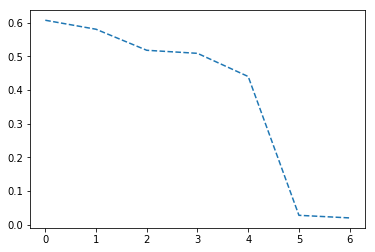

In [96]:
#incoming traffic by weekday
net_incoming_byDay = bike_availability_df.net_incoming_traffic.groupby(bike_availability_df.index.dayofweek).mean()
net_incoming_byDay.index = [0,1,2,3,4,5,6]
net_incoming_byDay.plot(style='--')
plt.show()

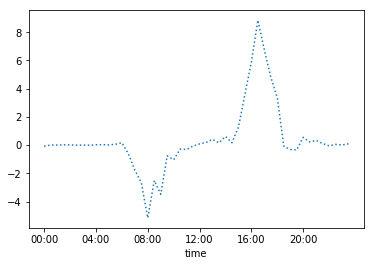

In [55]:
#incoming traffic by hour
net_incoming_byHour = bike_availability_df.net_incoming_traffic.groupby(bike_availability_df.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
net_incoming_byHour.plot(xticks=hourly_ticks, style=':')
plt.show()

In [90]:
bike_availability_df['timestamp'] = bike_availability_df.index.time

In [97]:
#Mapping net_incoming average by weekday and by hour to source data set
def mapNetIncoming_byTime (row): 
    for x in net_incoming_byHour.index:       
        if row == x:
            return net_incoming_byHour[x]

def mapNetIncoming_byWeekDay (row):
    for x in net_incoming_byDay.index:
        if row == x:
            return net_incoming_byDay[x]
        

In [98]:
bike_availability_df['net_incoming_overall_by_hour'] = bike_availability_df['timestamp'].apply(lambda row: mapNetIncoming_byTime(row))
bike_availability_df['net_incoming_overall_by_weekday'] = bike_availability_df['day_of_week'].apply(lambda row: mapNetIncoming_byWeekDay(row))

In [100]:
#Getting the ratio of net_incoming_traffic in the 24 hour window AND the net incoming traffic mean for the specific weekday
bike_availability_df['net_incoming_traffic_ratio_1'] = bike_availability_df['net_incoming_traffic_24Hr']/bike_availability_df['net_incoming_overall_by_weekday']
bike_availability_df['net_incoming_traffic_ratio_2'] = bike_availability_df['net_incoming_traffic']/bike_availability_df['net_incoming_overall_by_hour']


In [101]:
bike_availability_df.tail(50)

,station_id,bikes_available,docks_available,outgoing,incoming,replenish,outgoing_24H,incoming_24H,outgoing-incoming-ratio,avg_bikes_available,net_incoming_traffic,net_incoming_traffic_24Hr,incoming_traffic,day_of_week,timestamp,net_incoming_overall_by_hour,net_incoming_overall_by_weekday,net_incoming_traffic_ratio_1,net_incoming_traffic_ratio_2
time,,,,,,,,,,,,,,,,,,,
2015-08-30 23:00:00,70.0,13.0,6.0,0.0,0.0,0,0.208333,0.166667,1.250000,13.000000,0.0,-0.041667,-0.000000,6,23:00:00,0.010914,0.020238,-2.058824,0.000000
2015-08-30 23:30:00,70.0,13.0,6.0,0.0,0.0,0,0.208333,0.166667,1.250000,13.000000,0.0,-0.041667,-0.000000,6,23:30:00,0.094262,0.020238,-2.058824,0.000000
2015-08-31 00:00:00,70.0,13.0,6.0,0.0,0.0,0,0.208333,0.166667,1.250000,13.000000,0.0,-0.041667,-0.000000,0,00:00:00,-0.079235,0.607462,-0.068591,-0.000000
2015-08-31 00:30:00,70.0,13.0,6.0,0.0,0.0,0,0.208333,0.166667,1.250000,13.000000,0.0,-0.041667,-0.000000,0,00:30:00,0.010929,0.607462,-0.068591,0.000000
2015-08-31 01:00:00,70.0,13.0,6.0,0.0,0.0,0,0.208333,0.166667,1.250000,13.000000,0.0,-0.041667,-0.000000,0,01:00:00,0.009563,0.607462,-0.068591,0.000000
2015-08-31 01:30:00,70.0,13.0,6.0,0.0,0.0,0,0.208333,0.166667,1.250000,13.000000,0.0,-0.041667,-0.000000,0,01:30:00,0.023224,0.607462,-0.068591,0.000000
2015-08-31 02:00:00,70.0,13.0,6.0,0.0,0.0,0,0.208333,0.166667,1.250000,13.000000,0.0,-0.041667,-0.000000,0,02:00:00,0.016393,0.607462,-0.068591,0.000000
2015-08-31 02:30:00,70.0,13.0,6.0,0.0,0.0,0,0.208333,0.166667,1.250000,13.000000,0.0,-0.041667,-0.000000,0,02:30:00,0.002732,0.607462,-0.068591,0.000000
2015-08-31 03:00:00,70.0,13.0,6.0,0.0,0.0,0,0.208333,0.166667,1.250000,13.000000,0.0,-0.041667,-0.000000,0,03:00:00,0.004098,0.607462,-0.068591,0.000000


In [35]:
#identifying busy periods
##if avg_bikes_available <=7 then PEAK, if avg_bikes_available >7 and <=14 then moderate, if avg_bikes_available >14 then low

### Data Set for the model


In [105]:
bike_availability_df.replace([np.inf, -np.inf], np.nan)
Model_dataSet = bike_availability_df.dropna()

In [106]:
X_=Model_dataSet[['station_id', 'bikes_available', 'docks_available', 'outgoing', 'incoming','outgoing_24H', 'incoming_24H'
                 ,'outgoing-incoming-ratio','avg_bikes_available','net_incoming_traffic', 'net_incoming_traffic_24Hr', 'incoming_traffic',
                 'day_of_week', 'timestamp','net_incoming_overall_by_hour', 'net_incoming_overall_by_weekday', 'net_incoming_traffic_ratio_1',
                 'net_incoming_traffic_ratio_2']]

In [109]:
X_.dtypes

station_id                         float64
bikes_available                    float64
docks_available                    float64
outgoing                           float64
incoming                           float64
outgoing_24H                       float64
incoming_24H                       float64
outgoing-incoming-ratio            float64
avg_bikes_available                float64
net_incoming_traffic               float64
net_incoming_traffic_24Hr          float64
incoming_traffic                   float64
day_of_week                          int64
timestamp                           object
net_incoming_overall_by_hour       float64
net_incoming_overall_by_weekday    float64
net_incoming_traffic_ratio_1       float64
net_incoming_traffic_ratio_2       float64
dtype: object

In [37]:
X = np.array(X_dataSet.drop(['replenish', 'incoming_traffic', 'net_incoming_traffic_24Hr'],1))
y=np.array(X_dataSet['replenish'])
X_Train,X_Test, y_Train,y_Test = train_test_split(X,y,test_size = 0.3)
print(X)

[[70.          0.         19.         ...  1.08333333  1.66666667
  -1.        ]
 [70.          0.         19.         ...  1.11428571  0.83333333
   0.        ]
 [70.          0.         19.         ...  1.11428571  0.16666667
   0.        ]
 ...
 [70.         13.          6.         ...  0.66153846 12.
   0.        ]
 [70.         13.          6.         ...  0.66153846 12.33333333
   0.        ]
 [70.         14.          5.         ...  0.65151515 12.83333333
   2.        ]]


In [38]:
X_dataSet.dtypes

station_id                   float64
bikes_available              float64
docks_available              float64
outgoing                     float64
incoming                     float64
replenish                      int64
outgoing_24H                 float64
incoming_24H                 float64
outgoing-incoming-ratio      float64
avg_bikes_available          float64
net_incoming_traffic         float64
net_incoming_traffic_24Hr    float64
incoming_traffic             float64
dtype: object

In [39]:
param_grid_knn = {'n_neighbors':[20,30,40,50,60,70,80,90,100]}
knn = KNeighborsClassifier(weights='distance')

knn_cv = GridSearchCV(knn, param_grid_knn, cv=5, scoring = 'accuracy')

knn_cv.fit(X_Train, y_Train)

print('Grid Scores: ',knn_cv.grid_scores_)
print('Best Scores (Accuracy): ',knn_cv.best_score_)
print('Best Parameters: ',knn_cv.best_params_)

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').